In [1]:
"""
Two-Stage-To-Orbit Design Problem with Environmental Optimization
Modified to minimize Life Cycle Assessment (LCA) score instead of GLOW

L. BREVAULT (ONERA/DTIS), M. BALESDENT (ONERA/DTIS)
Modified for environmental optimization
"""

import numpy as np
import pandas as pd
import sys
np.set_printoptions(threshold=sys.maxsize)
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import OpenMDAO + CMA-ES optimization algorithm
import openmdao.api as om
import cma

# Import specific Python functions for launch vehicle design
import Launch_vehicle_Group
import post_traitement
import result_vizualization
import constants as Cst
import specifications as Spec

✓ Brightway2 and ecoinvent successfully loaded


In [2]:
# Create an OpenMDAO problem using the launch vehicle group with LCA
P_obj = om.Problem()
P_obj.model = Launch_vehicle_Group.Launcher_vehicle()
P_obj.setup()

In [3]:
# Fixed Point Iteration for single evaluation
def FPI(Pb):
    """
    Fixed Point Iteration for solving the coupled system
    """
    Pb.setup(check=False)

    # Define bounds for design variables including material compositions
    lowerbnd_exp = np.array([
        150.,   # Prop_mass_stage_1 (tonnes)
        20.,    # Prop_mass_stage_2 (tonnes)
        0.,     # theta_cmd_i
        -10.,   # theta_cmd_f
        -1.,    # ksi
        5.,     # Pitch_over_duration
        5.,     # Delta_vertical_phase
        1.,     # Delta_theta_pitch_over
        10., 10.,  # command_stage_1_exo (2 values)
    ])

    upperbnd_exp = np.array([
        600.,   # Prop_mass_stage_1 (tonnes)
        200.,   # Prop_mass_stage_2 (tonnes)
        50.,    # theta_cmd_i
        20.,    # theta_cmd_f
        1.,     # ksi
        20.,    # Pitch_over_duration
        20.,    # Delta_vertical_phase
        10.,    # Delta_theta_pitch_over
        70., 70.,  # command_stage_1_exo (2 values)
    ])

    # Optimal normalized values from CMA-ES
    x_optimal = np.array([0.23527546, 0.36153667, 0.39784285, 0.53903249, 
                          0.22424615, 0.96230176, 0.75167229, 0.8693451, 
                          0.44461484, 0.17382506])

    # Convert normalized to actual values
    XX = lowerbnd_exp + (upperbnd_exp - lowerbnd_exp) * x_optimal
    
    # Set default values
    Pb['Diameter_stage_1'] = 5.0
    Pb['Diameter_stage_2'] = 5.0
    Pb['Mass_flow_rate_stage_1'] = 300.
    Pb['Mass_flow_rate_stage_2'] = 200.
    Pb['Thrust_stage_1'] = 1000.
    Pb['Thrust_stage_2'] = 1000.
    Pb['OF_stage_1'] = 5.0
    Pb['OF_stage_2'] = 5.5
    Pb['Pc_stage_1'] = 80.
    Pb['Pc_stage_2'] = 60.
    Pb['Pe_stage_1'] = 1.0
    Pb['Pe_stage_2'] = 1.0
    Pb['N_eng_stage_1'] = 6.
    Pb['N_eng_stage_2'] = 1.
    Pb['Prop_mass_stage_1'] = XX[0] * 1e3 
    Pb['Prop_mass_stage_2'] = XX[1] * 1e3 
    Pb['thetacmd_i'] = XX[2]
    Pb['thetacmd_f'] = XX[3]
    Pb['ksi'] = XX[4]
    Pb['Pitch_over_duration'] = XX[5]
    Pb['Exit_nozzle_area_stage_1'] = 0.79
    Pb['Exit_nozzle_area_stage_2'] = 3.6305
    Pb['Delta_vertical_phase'] = XX[6]
    Pb['Delta_theta_pitch_over'] = XX[7]
    Pb['command_stage_1_exo'] = XX[8:10] 
    Pb['is_fallout'] = 0.
    
    # NEW: Set default material compositions (50/50 mix)
    Pb['k_SM_thrust_frame'] = 0.81  # 50% Al, 50% Composite for thrust frame
    Pb['k_SM_interstage'] = 0.85    # 50% Al, 50% Composite for interstage
    Pb['k_SM_intertank'] = 0.9      # 50% Al, 50% Composite for intertank

    # Fixed point iteration
    error = 100.
    Pb['Pdyn_max_dim'] = 40.
    k = 0

    print("\nRunning FPI with exact optimized FELIN baseline...")
    print(f"Prop_mass_stage_1: {XX[0]*1e3:.1f} kg")
    print(f"Prop_mass_stage_2: {XX[1]*1e3:.1f} kg")
    print(f"Trajectory params: theta_i={XX[2]:.1f}°, theta_f={XX[3]:.1f}°, ksi={XX[4]:.3f}")
    print(f"Command exo: [{XX[8]:.1f}, {XX[9]:.1f}]")

    while error > 1. and k < 20:
        Pb.run_model()
        # Replace the two lines that use 'max_pdyn_load_ascent_stage_1'
        qmax = np.max(Pb.get_val('pdyn_ascent'))
        error = abs(Pb.get_val('Pdyn_max_dim') - qmax/1e3)  # kPa target vs Pa series
        Pb.set_val('Pdyn_max_dim', qmax/1e3)

        #error = abs(Pb['Pdyn_max_dim'] - Pb['max_pdyn_load_ascent_stage_1']/1e3)
        #Pb['Pdyn_max_dim'] = Pb['max_pdyn_load_ascent_stage_1']/1e3
        k = k + 1
        if k <= 3 or k % 5 == 0:
            print(f'Fixed Point Iteration: {k}, error: {np.round(error[0],2)}, '
              f'Input pdyn max (kPa): {np.round(Pb["Pdyn_max_dim"][0],2)}')
            
    print(f"  Converged after {k} iterations")
    
    # Verify we get the expected masses
    print("\nAchieved configuration:")
    print(f"  GLOW: {Pb['GLOW'][0]/1000:.2f} tonnes (target: 381.46)")
    print(f"  Dry_mass_stage_1: {Pb['Dry_mass_stage_1'][0]/1000:.2f} tonnes")
    print(f"  Dry_mass_stage_2: {Pb['Dry_mass_stage_2'][0]/1000:.2f} tonnes")
    
    # Check trajectory performance
    nb_pts = int(Pb['Nb_pt_ascent'][0])
    alt_final = Pb['alt_ascent'][nb_pts-1] / 1000.0
    v_final = Pb['V_ascent'][nb_pts-1] / 1000.0
    print(f"\nTrajectory performance:")
    print(f"  Final altitude: {alt_final:.1f} km")
    print(f"  Final velocity: {v_final:.2f} km/s")

    return Pb



RUNNING FIXED POINT ITERATION

Running FPI with exact optimized FELIN baseline...
Prop_mass_stage_1: 255874.0 kg
Prop_mass_stage_2: 85076.6 kg
Trajectory params: theta_i=19.9°, theta_f=6.2°, ksi=-0.552
Command exo: [36.7, 20.4]
LOX mass: 285.2 tonnes
LH2 mass: 55.7 tonnes

=== LCA DEBUG ===
Structural mass: 29747.2 kg
LOX mass: 285216.2 kg
LH2 mass: 55734.4 kg

DETAILED LCA IMPACT BREAKDOWN

--- MATERIAL QUANTITIES ---
aluminum_7075       :     4681.7 kg (   4.68 tonnes)
aluminum_lithium    :    12791.7 kg (  12.79 tonnes)
cfrp                :     3398.4 kg (   3.40 tonnes)
steel               :     3513.6 kg (   3.51 tonnes)
titanium            :     1390.5 kg (   1.39 tonnes)
polyurethane_foam   :     1359.3 kg (   1.36 tonnes)
electronics         :     2612.2 kg (   2.61 tonnes)
lox                 :   285216.2 kg ( 285.22 tonnes)
lh2                 :    55734.4 kg (  55.73 tonnes)

Transport (tkm):        208230.7 tkm
Electricity:              5949.4 kWh

-----------------------

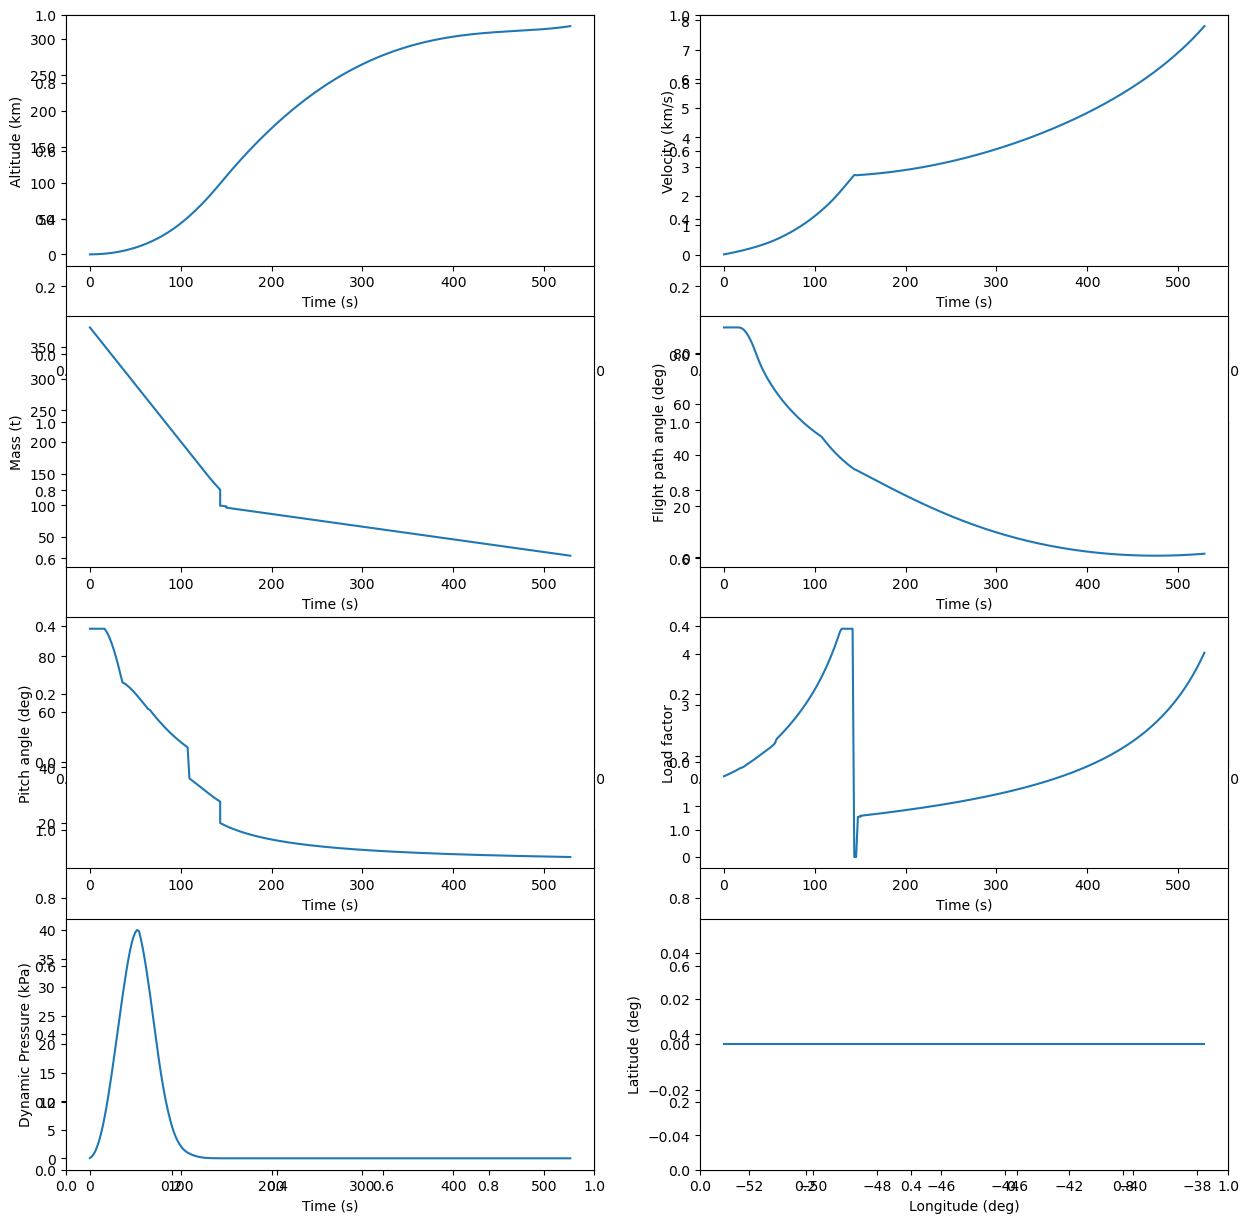

In [4]:
# Run Fixed Point Iteration
print("\n" + "="*60)
print("RUNNING FIXED POINT ITERATION")
print("="*60)
P_out = FPI(P_obj)
print("✓ FPI Complete")

print("\n=== What cycle.Traj sees for propulsion & sizing ===")
want = {
    "cycle.Traj.Mass_flow_rate_stage_1",
    "cycle.Traj.Mass_flow_rate_stage_2",
    "cycle.Traj.N_eng_stage_1",
    "cycle.Traj.N_eng_stage_2",
    "cycle.Traj.Exit_nozzle_area_stage_1",
    "cycle.Traj.Exit_nozzle_area_stage_2",
    "cycle.Traj.Isp_stage_1",
    "cycle.Traj.Isp_stage_2",
}
for name, _ in P_out.model.list_inputs(prom_name=False, out_stream=None):
    if name in want:
        try:
            print(f"{name:45s} -> {P_out.get_val(name)}")
        except Exception as e:
            print(f"{name:45s} -> <unreadable> ({e})")

result_vizualization.plots_output(P_out)


In [14]:
import numpy as np

t  = P_out.get_val('T_ascent').ravel()
h  = P_out.get_val('alt_ascent').ravel()
qd = P_out.get_val('pdyn_ascent').ravel()     # Pa

print(f"t_end = {np.nanmax(t):.1f} s")
print(f"h_end = {h[np.nanargmax(t)]:.1f} m")
print(f"pdyn_max = {np.nanmax(qd)/1e3:.1f} kPa")


t_end = 247.0 s
h_end = 10.0 m
pdyn_max = 1652.5 kPa


In [7]:
# Add this check after running FPI to verify LCA integration
print("\n=== LCA INTEGRATION STATUS CHECK ===")

# Check if LCA scores are being calculated
lca_score = float(P_out.get_val('Environmental.LCA_score').ravel()[0])
co2_eq    = float(P_out.get_val('Environmental.CO2_eq').ravel()[0])
glow      = float(P_out.get_val('GLOW').ravel()[0])

print(f"GLOW: {glow/1000:.1f} tonnes")
print(f"LCA Score: {lca_score:.3f} Pt")
print(f"CO2 emissions: {co2_eq/1000:.1f} tonnes")

if lca_score == 0:
    print("\n⚠ WARNING: LCA score is ZERO - Environmental discipline not working!")
    print("You should NOT start optimization until this is fixed.")
else:
    print(f"\n✓ LCA integration working - Score: {lca_score:.3f} Pt")
    print("You can proceed with optimization.")

# Check material masses are being calculated
al_mass   = float(P_out.get_val('Environmental.total_aluminum_7075_kg').ravel()[0])
comp_mass = float(P_out.get_val('Environmental.total_composite_kg').ravel()[0])

print(f"\nMaterial masses:")
print(f"Aluminum: {al_mass:.1f} kg")
print(f"Composite: {comp_mass:.1f} kg")

if al_mass == 0 and comp_mass == 0:
    print("⚠ Material masses are zero - check connections")


=== LCA INTEGRATION STATUS CHECK ===
GLOW: 380.7 tonnes
LCA Score: 269.296 Pt
CO2 emissions: 1066.7 tonnes

✓ LCA integration working - Score: 269.296 Pt
You can proceed with optimization.

Material masses:
Aluminum: 4681.7 kg
Composite: 3398.4 kg


In [ ]:
# Add this after running FPI(P_obj) in your notebook

print("\n" + "="*80)
print("DEBUG: COMPONENT MASS VERIFICATION")
print("="*80)

# Check if individual masses are being calculated
mass_components = [
    'M_eng', 'M_thrust_frame', 'M_FT', 'M_OxT', 
    'M_TPS_OxT', 'M_TPS_FT', 'M_TVC', 'M_avio', 
    'M_EPS', 'M_intertank', 'M_interstage'
]

print("\nStage 1 Component Masses:")
for comp in mass_components:
    try:
        val = P_out['cycle.Struct_1.' + comp][0] if 'cycle.Struct_1.' + comp in P_out else P_out[comp][0]
        print(f"  {comp:20s}: {val:10.1f} kg")
    except:
        print(f"  {comp:20s}: NOT FOUND")

# Check material fractions
print("\nMaterial Fractions:")
fractions = [
    ('Al_fraction_thrust_frame', 'Composite_fraction_thrust_frame'),
    ('Al_fraction_interstage', 'Composite_fraction_interstage'),
    ('Al_fraction_intertank', 'Composite_fraction_intertank')
]

for al_frac, comp_frac in fractions:
    try:
        al_val = P_out['cycle.Struct_1.' + al_frac][0] if 'cycle.Struct_1.' + al_frac in P_out else P_out[al_frac][0]
        comp_val = P_out['cycle.Struct_1.' + comp_frac][0] if 'cycle.Struct_1.' + comp_frac in P_out else P_out[comp_frac][0]
        print(f"  {al_frac[:20]:20s}: Al={al_val:.2f}, Composite={comp_val:.2f}")
    except:
        print(f"  {al_frac[:20]:20s}: NOT FOUND")

# Check if Environmental discipline is receiving inputs
print("\nEnvironmental Discipline Inputs:")
env_inputs = [
    'M_eng_stage_1', 'M_thrust_frame_stage_1', 'Dry_mass_stage_2',
    'Prop_mass_stage_1', 'Prop_mass_stage_2', 'OF_stage_1', 'OF_stage_2'
]

for inp in env_inputs:
    try:
        val = P_out['cycle.Environmental.' + inp][0] if 'cycle.Environmental.' + inp in P_out else P_out['Environmental.' + inp][0]
        print(f"  {inp:30s}: {val:12.1f}")
    except:
        print(f"  {inp:30s}: NOT FOUND")

# Check material totals
print("\nMaterial Totals from Environmental:")
material_outputs = [
    'total_aluminum_7075_kg', 'total_aluminum_lithium_kg', 
    'total_composite_kg', 'total_steel_kg', 'total_other_kg'
]

for mat in material_outputs:
    try:
        val = P_out['cycle.Environmental.' + mat][0] if 'cycle.Environmental.' + mat in P_out else P_out['Environmental.' + mat][0]
        print(f"  {mat:30s}: {val:10.1f} kg")
    except:
        print(f"  {mat:30s}: NOT FOUND")

# Check if LCA is actually being calculated
print("\nLCA Calculation Status:")
try:
    # Check if using placeholder or real LCA
    import brightway2 as bw
    print("  Brightway2 imported: YES")
    
    # Check current project
    try:
        current = bw.projects.current
        print(f"  Current project: {current}")
        
        # Check if ecoinvent is available
        if "ecoinvent 3.8 cutoff" in bw.databases:
            print("  Ecoinvent 3.8 found: YES")
        else:
            print("  Ecoinvent 3.8 found: NO - USING PLACEHOLDERS")
    except:
        print("  Brightway2 project: NOT SET - USING PLACEHOLDERS")
        
except ImportError:
    print("  Brightway2 imported: NO - USING PLACEHOLDERS")

print("="*80)

In [ ]:
"""
Complete diagnostic script for LCA integration issues
Run this after your FPI to identify problems
"""

import numpy as np
import sys

def diagnose_lca_integration(P_out):
    """
    Comprehensive diagnostic for LCA integration
    """
    print("\n" + "="*80)
    print("LCA INTEGRATION DIAGNOSTIC REPORT")
    print("="*80)
    
    issues_found = []
    
    # 1. Check OpenMDAO variable paths
    print("\n1. CHECKING VARIABLE PATHS:")
    print("-" * 40)
    
    # List all variables to understand naming convention
    all_vars = list(P_out.keys())
    struct_vars = [v for v in all_vars if 'Struct_1' in v]
    env_vars = [v for v in all_vars if 'Environmental' in v]
    
    print(f"Total variables: {len(all_vars)}")
    print(f"Struct_1 variables: {len(struct_vars)}")
    print(f"Environmental variables: {len(env_vars)}")
    
    if len(struct_vars) < 15:
        issues_found.append("Missing Struct_1 output variables")
        print("  ⚠ Issue: Not all component masses are exposed from Struct_1")
    
    if len(env_vars) < 20:
        issues_found.append("Environmental discipline outputs missing")
        print("  ⚠ Issue: Environmental discipline may not be properly connected")
    
    # 2. Check mass flow from structural to environmental
    print("\n2. MASS DATA FLOW CHECK:")
    print("-" * 40)
    
    component_masses = {
        'M_eng': 0.0,
        'M_thrust_frame': 0.0,
        'M_FT': 0.0,
        'M_OxT': 0.0,
        'M_TPS_OxT': 0.0,
        'M_TPS_FT': 0.0,
        'M_TVC': 0.0,
        'M_avio': 0.0,
        'M_EPS': 0.0,
        'M_intertank': 0.0,
        'M_interstage': 0.0
    }
    
    # Try different path patterns
    path_patterns = ['cycle.Struct_1.{}', '{}', 'Struct_1.{}']
    
    for comp in component_masses:
        found = False
        for pattern in path_patterns:
            var_path = pattern.format(comp)
            if var_path in P_out:
                try:
                    component_masses[comp] = float(P_out[var_path][0])
                    found = True
                    break
                except:
                    pass
        
        if not found:
            issues_found.append(f"Cannot find {comp} in outputs")
            print(f"  ⚠ {comp}: NOT FOUND")
        else:
            print(f"  ✓ {comp}: {component_masses[comp]:.1f} kg")
    
    total_component_mass = sum(component_masses.values())
    dry_mass_1 = float(P_out.get('Dry_mass_stage_1', [0])[0])
    
    print(f"\nSum of components: {total_component_mass:.1f} kg")
    print(f"Dry_mass_stage_1: {dry_mass_1:.1f} kg")
    
    # Account for 3000 kg auxiliary mass
    expected_sum = total_component_mass + 3000
    if abs(expected_sum - dry_mass_1) > 100:
        issues_found.append(f"Mass inconsistency: components sum to {expected_sum:.1f} but dry mass is {dry_mass_1:.1f}")
        print(f"  ⚠ Mass mismatch: {abs(expected_sum - dry_mass_1):.1f} kg difference")
    
    # 3. Check material fractions
    print("\n3. MATERIAL FRACTION CHECK:")
    print("-" * 40)
    
    k_SM_values = {
        'k_SM_thrust_frame': 0.0,
        'k_SM_interstage': 0.0,
        'k_SM_intertank': 0.0
    }
    
    for k_var in k_SM_values:
        for pattern in path_patterns:
            var_path = pattern.format(k_var)
            if var_path in P_out:
                k_SM_values[k_var] = float(P_out[var_path][0])
                break
    
    print(f"k_SM_thrust_frame: {k_SM_values['k_SM_thrust_frame']:.3f}")
    print(f"k_SM_interstage: {k_SM_values['k_SM_interstage']:.3f}")
    print(f"k_SM_intertank: {k_SM_values['k_SM_intertank']:.3f}")
    
    # Calculate expected fractions
    expected_fractions = {
        'thrust_frame': {
            'Al': (k_SM_values['k_SM_thrust_frame'] - 0.62) / 0.38,
            'Composite': 1.0 - (k_SM_values['k_SM_thrust_frame'] - 0.62) / 0.38
        },
        'interstage': {
            'Al': (k_SM_values['k_SM_interstage'] - 0.7) / 0.3,
            'Composite': 1.0 - (k_SM_values['k_SM_interstage'] - 0.7) / 0.3
        },
        'intertank': {
            'Al': (k_SM_values['k_SM_intertank'] - 0.8) / 0.2,
            'Composite': 1.0 - (k_SM_values['k_SM_intertank'] - 0.8) / 0.2
        }
    }
    
    for comp, fracs in expected_fractions.items():
        print(f"\n{comp}:")
        print(f"  Expected Al fraction: {fracs['Al']:.3f}")
        print(f"  Expected Composite fraction: {fracs['Composite']:.3f}")
        
        # Check if fractions are in valid range
        if fracs['Al'] < 0 or fracs['Al'] > 1:
            issues_found.append(f"{comp} Al fraction out of range: {fracs['Al']:.3f}")
            print(f"  ⚠ Al fraction out of [0,1] range!")
        if fracs['Composite'] < 0 or fracs['Composite'] > 1:
            issues_found.append(f"{comp} Composite fraction out of range: {fracs['Composite']:.3f}")
            print(f"  ⚠ Composite fraction out of [0,1] range!")
    
    # 4. Check LCA calculation
    print("\n4. LCA CALCULATION CHECK:")
    print("-" * 40)
    
    # Check if Brightway2 is properly configured
    try:
        import brightway2 as bw
        print("Brightway2 status: IMPORTED")
        
        try:
            current_project = bw.projects.current
            print(f"Current project: {current_project}")
            
            if "ecoinvent 3.8 cutoff" in bw.databases:
                print("Ecoinvent database: FOUND")
                
                # Test a simple LCA calculation
                eco = bw.Database("ecoinvent 3.8 cutoff")
                test_act = eco.random()
                test_lca = bw.LCA({test_act: 1.0}, ('EF v3.0', 'climate change', 'global warming potential (GWP100)'))
                test_lca.lci()
                test_lca.lcia()
                print(f"Test LCA calculation: SUCCESS (score={test_lca.score:.4f})")
                
            else:
                issues_found.append("Ecoinvent database not found")
                print("Ecoinvent database: NOT FOUND")
                print("  ⚠ LCA will use placeholder values")
                
        except Exception as e:
            issues_found.append(f"Brightway2 project error: {e}")
            print(f"Brightway2 project error: {e}")
            print("  ⚠ LCA will use placeholder values")
            
    except ImportError:
        issues_found.append("Brightway2 not installed")
        print("Brightway2 status: NOT INSTALLED")
        print("  ⚠ LCA will use placeholder values")
    
    # 5. Check environmental outputs
    print("\n5. ENVIRONMENTAL OUTPUTS CHECK:")
    print("-" * 40)
    
    env_outputs = {
        'LCA_score': 0.0,
        'ESA_single_score': 0.0,
        'CO2_eq': 0.0,
        'GWP_impact': 0.0,
        'total_aluminum_7075_kg': 0.0,
        'total_composite_kg': 0.0
    }
    
    for out in env_outputs:
        for prefix in ['Environmental.', 'cycle.Environmental.', '']:
            var_path = prefix + out
            if var_path in P_out:
                try:
                    env_outputs[out] = float(P_out[var_path][0])
                    break
                except:
                    pass
    
    for out, val in env_outputs.items():
        if val == 0.0:
            issues_found.append(f"Environmental output {out} is zero")
            print(f"  ⚠ {out}: {val} (possibly not calculated)")
        else:
            print(f"  ✓ {out}: {val:.3f}")
    
    # 6. Summary
    print("\n" + "="*80)
    print("DIAGNOSTIC SUMMARY")
    print("="*80)
    
    if issues_found:
        print(f"\n🔴 Found {len(issues_found)} issues:\n")
        for i, issue in enumerate(issues_found, 1):
            print(f"  {i}. {issue}")
        
        print("\nRECOMMENDED ACTIONS:")
        print("-" * 40)
        
        if "Missing Struct_1 output variables" in str(issues_found):
            print("1. Check that Dry_Mass_stage_1.py outputs are promoted correctly")
            print("   in Launch_vehicle_Group.py")
        
        if "Environmental discipline outputs missing" in str(issues_found):
            print("2. Verify Environmental_Discipline.py is properly imported and")
            print("   connected in Launch_vehicle_Group.py")
        
        if "Mass inconsistency" in str(issues_found):
            print("3. Check mass calculations in Mass_models.py")
        
        if "fraction out of range" in str(issues_found):
            print("4. Verify k_SM values are within correct ranges:")
            print("   - k_SM_thrust_frame: [0.62, 1.0]")
            print("   - k_SM_interstage: [0.7, 1.0]")
            print("   - k_SM_intertank: [0.8, 1.0]")
        
        if "Brightway2" in str(issues_found) or "Ecoinvent" in str(issues_found):
            print("5. Set up Brightway2 and import ecoinvent database:")
            print("   import brightway2 as bw")
            print("   bw.projects.set_current('LCA_FELIN')")
            print("   # Then import ecoinvent database")
        
    else:
        print("\n✅ No major issues detected!")
        print("\nSystem appears to be properly configured.")
    
    return issues_found

# Run the diagnostic
if __name__ == "__main__":
    # Assuming P_out is your problem output from FPI
    issues = diagnose_lca_integration(P_out)
    
    # Additional variable listing for debugging
    print("\n" + "="*80)
    print("COMPLETE VARIABLE LIST (first 20):")
    print("-" * 40)
    for i, (key, val) in enumerate(P_out.items()):
        if i >= 20:
            break
        try:
            if hasattr(val, '__len__'):
                print(f"{key}: {val[0] if len(val) > 0 else 'empty'}")
            else:
                print(f"{key}: {val}")
        except:
            print(f"{key}: <cannot display>")

In [ ]:
# FPI for optimization with material variables
def FPI_optim(x, lowerbnd_exp, upperbnd_exp, Pb):
    """
    Fixed Point Iteration for optimization including material composition variables
    """
    Pb.setup(check=False)
    XX = lowerbnd_exp + (upperbnd_exp - lowerbnd_exp)*x
    
    # Fixed parameters
    Pb['Diameter_stage_1'] = 5.0
    Pb['Diameter_stage_2'] = 5.0
    Pb['Mass_flow_rate_stage_1'] = 300.
    Pb['Mass_flow_rate_stage_2'] = 200.
    Pb['Thrust_stage_1'] = 1000.
    Pb['Thrust_stage_2'] = 1000.
    Pb['OF_stage_1'] = 5.
    Pb['OF_stage_2'] = 5.5
    Pb['Pc_stage_1'] = 80.0
    Pb['Pc_stage_2'] = 60.0
    Pb['Pe_stage_1'] = 1.0
    Pb['Pe_stage_2'] = 1.0
    Pb['N_eng_stage_1'] = 6.
    Pb['N_eng_stage_2'] = 1.
    
    # Design variables from optimization
    Pb['Prop_mass_stage_1'] = 255
    Pb['Prop_mass_stage_2'] = 85
    Pb['thetacmd_i'] = XX[2]
    Pb['thetacmd_f'] = XX[3] 
    Pb['ksi'] = XX[4]
    Pb['Pitch_over_duration'] = XX[5]
    Pb['Delta_vertical_phase'] = XX[6]
    Pb['Delta_theta_pitch_over'] = XX[7]        
    Pb['command_stage_1_exo'] = XX[8:10]
    
    # NEW: Material composition design variables
    Pb['k_SM_thrust_frame'] = XX[10]
    Pb['k_SM_interstage'] = XX[11]
    
    # Fixed parameters
    Pb['Exit_nozzle_area_stage_1'] = 0.79
    Pb['Exit_nozzle_area_stage_2'] = 3.6305
    Pb['is_fallout'] = 0.

    # Fixed point iteration
    error = 100.
    Pb['Pdyn_max_dim'] = 40.
    k = 0
    while error > 1. and k < 20:
        Pb.run_model()
        error = abs(Pb['Pdyn_max_dim'] - Pb['max_pdyn_load_ascent_stage_1']/1e3)
        Pb['Pdyn_max_dim'] = Pb['max_pdyn_load_ascent_stage_1']/1e3
        k = k + 1
    return Pb

In [5]:
# Environmental Objective Function
def Objective_function_LCA(x, lowerbnd_exp, upperbnd_exp, Pb, simu):
    """
    Objective function for environmental optimization
    Minimizes LCA score while respecting all trajectory constraints
    """
    P_out = FPI_optim(x, lowerbnd_exp, upperbnd_exp, Pb)
    GLOW, contraintes = post_traitement.post_traitement(P_out)
    LCA_score = P_out['Environmental.LCA_score'][0]
    
    if simu == 0:  # Optimization mode
        if len(np.where(contraintes > 1e-2)[0]) == 0:
            # All constraints satisfied - minimize LCA score
            # Scale LCA score for optimizer (assuming typical values 1e5-1e6)
            return LCA_score / 1e5
        else:
            # Constraints not satisfied - minimize constraint violation
            cont = np.sum(contraintes[np.where(contraintes > 0)[0]])
            return 1000 + cont  # Large penalty for constraint violations
    else:  # Evaluation mode
        if len(np.where(contraintes > 1e-2)[0]) == 0:
            return LCA_score, GLOW, -5  # Return both LCA and GLOW for analysis
        else:
            return LCA_score, GLOW, contraintes

In [6]:
# Multi-objective function (optional - for Pareto front analysis)
def Objective_function_multiobjective(x, lowerbnd_exp, upperbnd_exp, Pb, w_lca=0.7, w_glow=0.3):
    """
    Multi-objective function balancing LCA and GLOW
    w_lca: weight for LCA score (default 0.7)
    w_glow: weight for GLOW (default 0.3)
    """
    P_out = FPI_optim(x, lowerbnd_exp, upperbnd_exp, Pb)
    GLOW, contraintes = post_traitement.post_traitement(P_out)
    LCA_score = P_out['Environmental.LCA_score'][0]
    
    if len(np.where(contraintes > 1e-2)[0]) == 0:
        # Normalize objectives (typical ranges)
        LCA_norm = LCA_score / 1e6  # Assuming LCA ~1e6
        GLOW_norm = GLOW / 5e5      # Assuming GLOW ~500 tonnes
        
        # Weighted sum
        obj = w_lca * LCA_norm + w_glow * GLOW_norm
        return obj
    else:
        # Constraints not satisfied
        cont = np.sum(contraintes[np.where(contraintes > 0)[0]])
        return 1000 + cont


OPTIMIZATION SETUP
Optimizing for minimum LCA score

Starting CMA-ES optimization...
Number of design variables: 12
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 12 (seed=2, Sun Sep 21 14:55:50 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 8.009183060437573e+03 1.0e+00 2.04e-01  2e-01  2e-01 2:13.6
    2     32 8.003241047502306e+03 1.2e+00 1.86e-01  2e-01  2e-01 4:11.0
    3     48 1.009731546013860e+03 1.3e+00 1.87e-01  2e-01  2e-01 5:55.1
    4     64 1.075919802538128e+03 1.3e+00 1.96e-01  2e-01  2e-01 7:57.5
    5     80 1.022323393950461e+03 1.4e+00 2.03e-01  2e-01  2e-01 9:54.8
    6     96 1.009045174208175e+03 1.5e+00 2.06e-01  2e-01  2e-01 11:34.3
    7    112 1.029572041855404e+03 1.6e+00 2.05e-01  2e-01  2e-01 13:13.5
    8    128 1.051430950017795e+03 1.7e+00 2.02e-01  2e-01  2e-01 15:14.3
    9    144 1.015365524776739e+03 1.7e+00 1.99e-01  2e-01  2e-01 16:48.4
   10    160 1.031674142703415e+03 1.7e+00 1.92e-01  2e-01  2e-

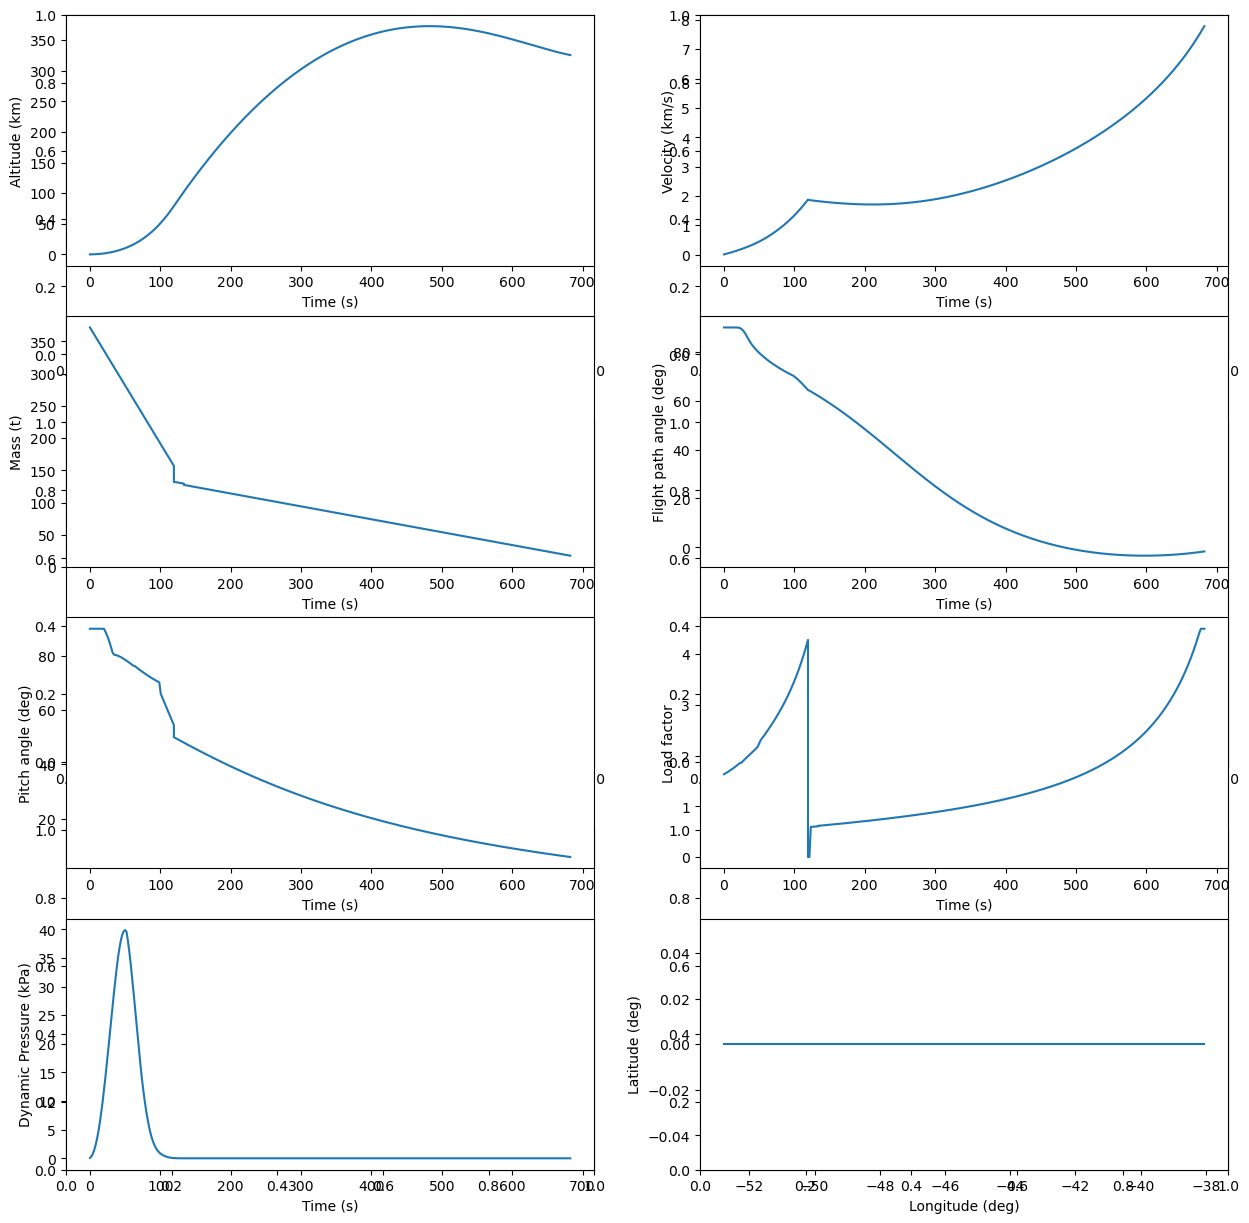

In [14]:
# Setup CMA-ES optimization
print("\n" + "="*60)
print("OPTIMIZATION SETUP")
print("="*60)

# CMA-ES options
lower = np.zeros([1, len(lowerbnd_exp)])
upper = np.ones([1, len(upperbnd_exp)])  
bound_cma = np.array([lower[0], upper[0]])

options = {
    'ftarget': -1e7,       # Target (not used in practice)
    'tolfun': 1e-5,        # Function tolerance
    'tolx': 1e-6,          # Variable tolerance
    'seed': 2,             # Random seed for reproducibility
    'bounds': [bound_cma[0], bound_cma[1]],
    'popsize': 16,         # Increased for more design variables
    'maxiter': 150,        # More iterations for material optimization
    'verb_disp': 1         # Display progress
}

# Choose optimization mode
optimization_mode = input("\nSelect optimization mode:\n"
                         "1. Minimize LCA only\n"
                         "2. Multi-objective (LCA + GLOW)\n"
                         "Enter choice (1 or 2): ")

if optimization_mode == "2":
    w_lca = float(input("Enter LCA weight (0-1, default 0.7): ") or "0.7")
    w_glow = 1.0 - w_lca
    print(f"Using weights: LCA={w_lca:.2f}, GLOW={w_glow:.2f}")
    critere_cma = lambda x: Objective_function_multiobjective(x, lowerbnd_exp, upperbnd_exp, 
                                                             P_obj, w_lca, w_glow)
else:
    print("Optimizing for minimum LCA score")
    simu = 0
    critere_cma = lambda x: Objective_function_LCA(x, lowerbnd_exp, upperbnd_exp, P_obj, simu)

# Initial guess (normalized)
init = np.ones(len(lowerbnd_exp)) * 0.5
# Start with mostly aluminum (conservative)
init[-2] = 0.8  # k_SM_thrust_frame normalized
init[-1] = 0.8  # k_SM_interstage normalized

print("\nStarting CMA-ES optimization...")
print("Number of design variables:", len(lowerbnd_exp))

# Run optimization
res = cma.fmin(critere_cma, init, 0.2, options)

# Results analysis
print("\n" + "="*60)
print("OPTIMIZATION RESULTS")
print("="*60)

print('Optimal design variable values:', res[0])

# Evaluate optimal solution
simu = 1
LCA_opt, GLOW_opt, constraints_check = Objective_function_LCA(res[0], lowerbnd_exp, upperbnd_exp, 
                                                              P_obj, simu)

print(f"\nOptimal LCA Score: {LCA_opt:.2f}")
print(f"Optimal GLOW: {GLOW_opt/1e3:.2f} tonnes")

# Get detailed results
P_out_opt = FPI_optim(res[0], lowerbnd_exp, upperbnd_exp, P_obj)

# Material composition results
XX_opt = lowerbnd_exp + (upperbnd_exp - lowerbnd_exp) * res[0]
k_SM_tf_opt = XX_opt[10]
k_SM_is_opt = XX_opt[11]

al_frac_tf_opt = (k_SM_tf_opt - 0.62) / 0.38
comp_frac_tf_opt = 1.0 - al_frac_tf_opt
al_frac_is_opt = (k_SM_is_opt - 0.7) / 0.3
comp_frac_is_opt = 1.0 - al_frac_is_opt

print(f"\nOptimal Material Composition:")
print(f"Thrust Frame: {al_frac_tf_opt*100:.1f}% Al, {comp_frac_tf_opt*100:.1f}% Composite")
print(f"Interstage: {al_frac_is_opt*100:.1f}% Al, {comp_frac_is_opt*100:.1f}% Composite")

# Detailed results table
data_opt = [[
    P_out_opt['GLOW'][0]/1e3,
    P_out_opt['Dry_mass_stage_1'][0]/1e3,
    P_out_opt['Dry_mass_stage_2'][0]/1e3,
    P_out_opt['Prop_mass_stage_1'][0]/1e3,
    P_out_opt['Prop_mass_stage_2'][0]/1e3,
    P_out_opt['Environmental.LCA_score'][0]/1e3,
    P_out_opt['Environmental.CO2_eq'][0]/1e3,
    P_out_opt['Environmental.Energy_consumption'][0]/1e6
]]

df_opt = pd.DataFrame(data_opt, columns=[
    "GLOW (t)", "Dry_mass_1 (t)", "Dry_mass_2 (t)", 
    "Prop_mass_1 (t)", "Prop_mass_2 (t)",
    "LCA Score", "CO2 eq (t)", "Energy (TJ)"
])

print("\nOptimized Design:")
print(df_opt.round(3))

# Environmental breakdown
print("\n" + "="*60)
print("ENVIRONMENTAL IMPACT BREAKDOWN")
print("="*60)
print(f"Stage 1 LCA: {P_out_opt['Environmental.LCA_stage_1'][0]:.2f}")
print(f"Stage 2 LCA: {P_out_opt['Environmental.LCA_stage_2'][0]:.2f}")
print(f"Propellants LCA: {P_out_opt['Environmental.LCA_propellants'][0]:.2f}")

# Plot results
result_vizualization.plots_output(P_out_opt)

# Save results
results_dict = {
    'design_variables': res[0],
    'GLOW_kg': P_out_opt['GLOW'][0],
    'LCA_score': P_out_opt['Environmental.LCA_score'][0],
    'CO2_eq_kg': P_out_opt['Environmental.CO2_eq'][0],
    'Energy_MJ': P_out_opt['Environmental.Energy_consumption'][0],
    'k_SM_thrust_frame': k_SM_tf_opt,
    'k_SM_interstage': k_SM_is_opt,
    'Al_fraction_thrust_frame': al_frac_tf_opt,
    'Al_fraction_interstage': al_frac_is_opt
}


OPTIMIZATION SETUP
Using weights: LCA=0.70, GLOW=0.30

Starting CMA-ES optimization...
Number of design variables: 12
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 12 (seed=2, Sun Sep 21 18:43:48 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 8.009183060437573e+03 1.0e+00 2.04e-01  2e-01  2e-01 2:02.4
    2     32 8.003241047502306e+03 1.2e+00 1.86e-01  2e-01  2e-01 3:55.8
    3     48 1.009731546013860e+03 1.3e+00 1.87e-01  2e-01  2e-01 5:37.5
    4     64 1.075919802538128e+03 1.3e+00 1.96e-01  2e-01  2e-01 7:36.4
    5     80 1.022323393950461e+03 1.4e+00 2.03e-01  2e-01  2e-01 9:30.7
    6     96 1.009045174208175e+03 1.5e+00 2.06e-01  2e-01  2e-01 11:06.5
    7    112 1.029572041855404e+03 1.6e+00 2.05e-01  2e-01  2e-01 12:43.5
    8    128 1.051430950017795e+03 1.7e+00 2.02e-01  2e-01  2e-01 14:41.2
    9    144 1.015365524776739e+03 1.7e+00 1.99e-01  2e-01  2e-01 16:14.9
   10    160 1.031674142703415e+03 1.7e+00 1.92e-01  2e-01  2

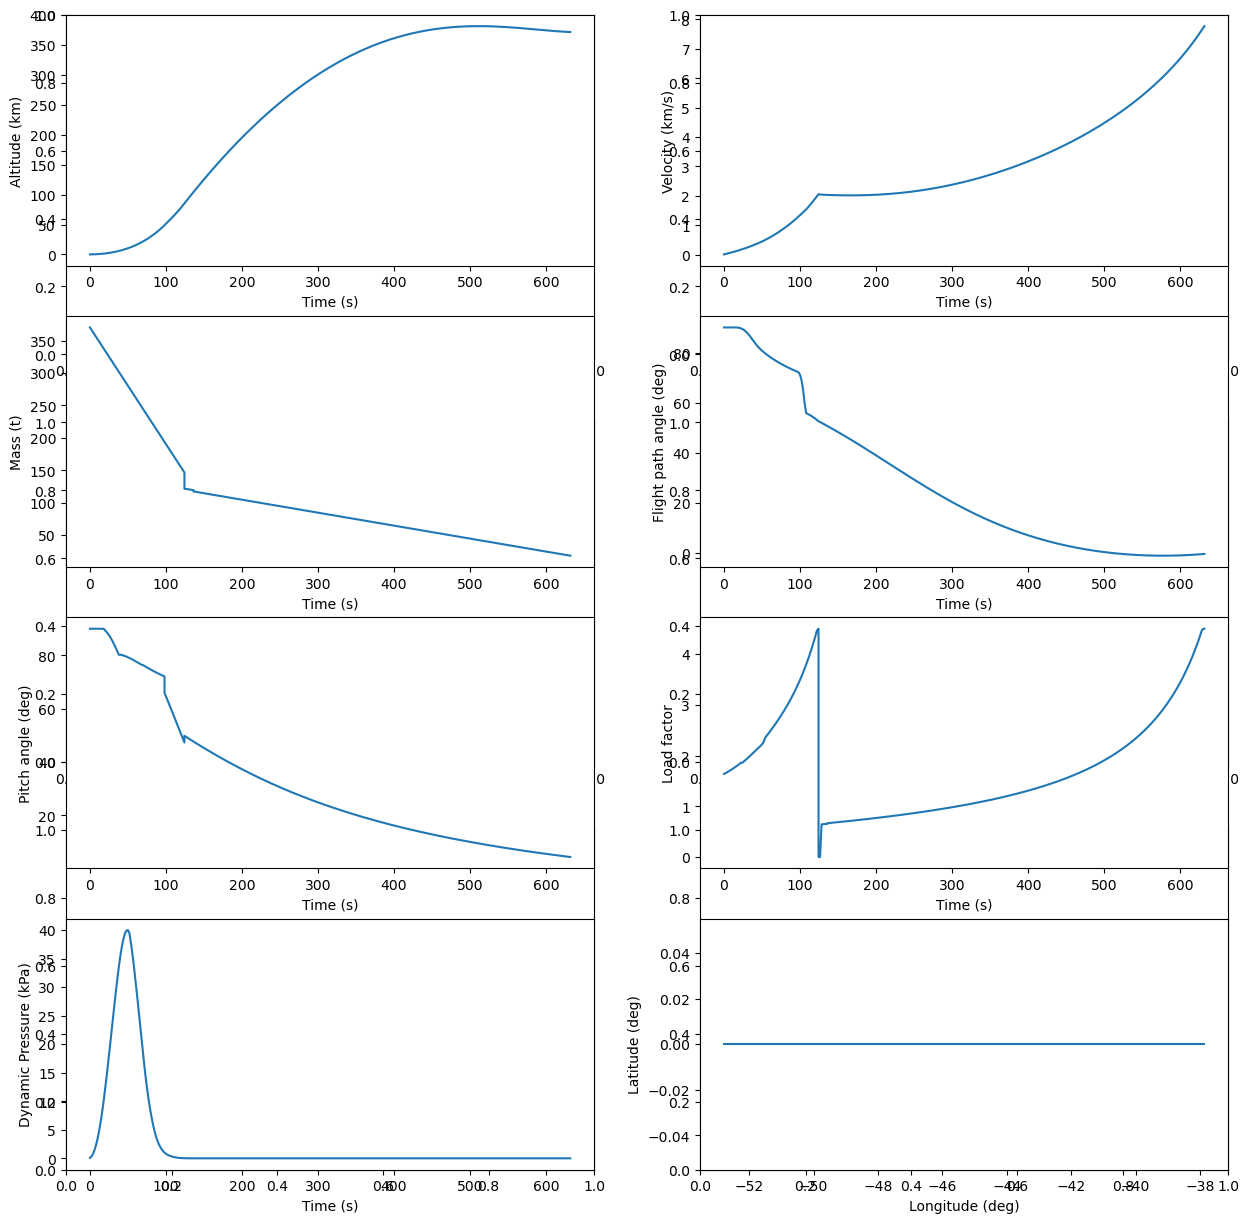

In [17]:
# Setup CMA-ES optimization
print("\n" + "="*60)
print("OPTIMIZATION SETUP")
print("="*60)

# CMA-ES options
lower = np.zeros([1, len(lowerbnd_exp)])
upper = np.ones([1, len(upperbnd_exp)])  
bound_cma = np.array([lower[0], upper[0]])

options = {
    'ftarget': -1e7,       # Target (not used in practice)
    'tolfun': 1e-5,        # Function tolerance
    'tolx': 1e-6,          # Variable tolerance
    'seed': 2,             # Random seed for reproducibility
    'bounds': [bound_cma[0], bound_cma[1]],
    'popsize': 16,         # Increased for more design variables
    'maxiter': 150,        # More iterations for material optimization
    'verb_disp': 1         # Display progress
}

# Choose optimization mode
optimization_mode = input("\nSelect optimization mode:\n"
                         "1. Minimize LCA only\n"
                         "2. Multi-objective (LCA + GLOW)\n"
                         "Enter choice (1 or 2): ")

if optimization_mode == "2":
    w_lca = float(input("Enter LCA weight (0-1, default 0.7): ") or "0.7")
    w_glow = 1.0 - w_lca
    print(f"Using weights: LCA={w_lca:.2f}, GLOW={w_glow:.2f}")
    critere_cma = lambda x: Objective_function_multiobjective(x, lowerbnd_exp, upperbnd_exp, 
                                                             P_obj, w_lca, w_glow)
else:
    print("Optimizing for minimum LCA score")
    simu = 0
    critere_cma = lambda x: Objective_function_LCA(x, lowerbnd_exp, upperbnd_exp, P_obj, simu)

# Initial guess (normalized)
init = np.ones(len(lowerbnd_exp)) * 0.5
# Start with mostly aluminum (conservative)
init[-2] = 0.8  # k_SM_thrust_frame normalized
init[-1] = 0.8  # k_SM_interstage normalized

print("\nStarting CMA-ES optimization...")
print("Number of design variables:", len(lowerbnd_exp))

# Run optimization
res = cma.fmin(critere_cma, init, 0.2, options)

# Results analysis
print("\n" + "="*60)
print("OPTIMIZATION RESULTS")
print("="*60)

print('Optimal design variable values:', res[0])

# Evaluate optimal solution
simu = 1
LCA_opt, GLOW_opt, constraints_check = Objective_function_LCA(res[0], lowerbnd_exp, upperbnd_exp, 
                                                              P_obj, simu)

print(f"\nOptimal LCA Score: {LCA_opt:.2f}")
print(f"Optimal GLOW: {GLOW_opt/1e3:.2f} tonnes")

# Get detailed results
P_out_opt = FPI_optim(res[0], lowerbnd_exp, upperbnd_exp, P_obj)

# Material composition results
XX_opt = lowerbnd_exp + (upperbnd_exp - lowerbnd_exp) * res[0]
k_SM_tf_opt = XX_opt[10]
k_SM_is_opt = XX_opt[11]

al_frac_tf_opt = (k_SM_tf_opt - 0.62) / 0.38
comp_frac_tf_opt = 1.0 - al_frac_tf_opt
al_frac_is_opt = (k_SM_is_opt - 0.7) / 0.3
comp_frac_is_opt = 1.0 - al_frac_is_opt

print(f"\nOptimal Material Composition:")
print(f"Thrust Frame: {al_frac_tf_opt*100:.1f}% Al, {comp_frac_tf_opt*100:.1f}% Composite")
print(f"Interstage: {al_frac_is_opt*100:.1f}% Al, {comp_frac_is_opt*100:.1f}% Composite")

# Detailed results table
data_opt = [[
    P_out_opt['GLOW'][0]/1e3,
    P_out_opt['Dry_mass_stage_1'][0]/1e3,
    P_out_opt['Dry_mass_stage_2'][0]/1e3,
    P_out_opt['Prop_mass_stage_1'][0]/1e3,
    P_out_opt['Prop_mass_stage_2'][0]/1e3,
    P_out_opt['Environmental.LCA_score'][0]/1e3,
    P_out_opt['Environmental.CO2_eq'][0]/1e3,
    P_out_opt['Environmental.Energy_consumption'][0]/1e6
]]

df_opt = pd.DataFrame(data_opt, columns=[
    "GLOW (t)", "Dry_mass_1 (t)", "Dry_mass_2 (t)", 
    "Prop_mass_1 (t)", "Prop_mass_2 (t)",
    "LCA Score", "CO2 eq (t)", "Energy (TJ)"
])

print("\nOptimized Design:")
print(df_opt.round(3))

# Environmental breakdown
print("\n" + "="*60)
print("ENVIRONMENTAL IMPACT BREAKDOWN")
print("="*60)
print(f"Stage 1 LCA: {P_out_opt['Environmental.LCA_stage_1'][0]:.2f}")
print(f"Stage 2 LCA: {P_out_opt['Environmental.LCA_stage_2'][0]:.2f}")
print(f"Propellants LCA: {P_out_opt['Environmental.LCA_propellants'][0]:.2f}")

# Plot results
result_vizualization.plots_output(P_out_opt)

# Save results
results_dict = {
    'design_variables': res[0],
    'GLOW_kg': P_out_opt['GLOW'][0],
    'LCA_score': P_out_opt['Environmental.LCA_score'][0],
    'CO2_eq_kg': P_out_opt['Environmental.CO2_eq'][0],
    'Energy_MJ': P_out_opt['Environmental.Energy_consumption'][0],
    'k_SM_thrust_frame': k_SM_tf_opt,
    'k_SM_interstage': k_SM_is_opt,
    'Al_fraction_thrust_frame': al_frac_tf_opt,
    'Al_fraction_interstage': al_frac_is_opt
}

In [16]:
print("\nResults saved to 'optimization_results_LCA.json'")

# Compare with baseline
print("\n" + "="*60)
print("IMPROVEMENT FROM BASELINE")
print("="*60)
baseline_lca = P_out['Environmental.LCA_score'][0]
baseline_glow = P_out['GLOW'][0]

lca_reduction = (baseline_lca - P_out_opt['Environmental.LCA_score'][0]) / baseline_lca * 100
glow_change = (P_out_opt['GLOW'][0] - baseline_glow) / baseline_glow * 100

print(f"LCA Reduction: {lca_reduction:.1f}%")
print(f"GLOW Change: {glow_change:+.1f}%")

print("\n" + "="*60)
print("OPTIMIZATION COMPLETE")
print("="*60)


Results saved to 'optimization_results_LCA.json'

IMPROVEMENT FROM BASELINE
LCA Reduction: 0.0%
GLOW Change: +0.0%

OPTIMIZATION COMPLETE
